In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.multivariate.pca import PCA
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.api import VAR
import numpy as np
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
prepdf = pd.read_csv('better_prepdf.csv')#,index_col=0)

filled_df = prepdf.copy()

In [ ]:
prepdf_nonpca = prepdf.copy()
prepdf_nonpca.drop(columns=['PS_DS_DAY', 'DIG_SLUDGE_DEWATER_FECL3_DAY','TWAS_CENT_VS_DAY', 'PS_VS_DAY', 'TWAS_CENT_DS_DAY','PS_Q_DAY'  ], inplace=True)
filled_df = prepdf_nonpca.copy()
filled_df.set_index("Date", inplace=True)

#df_nonpca = prepdf_nonpca.dropna(axis=0)


In [ ]:
percent_missing = filled_df.isnull().sum() * 100 / len(filled_df)
missing_value_df = pd.DataFrame({'column_name': filled_df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values(by='percent_missing', ascending=False)

,column_name,percent_missing
TWAS_DAF_VS_DAY,TWAS_DAF_VS_DAY,40.775558
DIGESTED_SLUDGE_VS_3_PER_WEEK,DIGESTED_SLUDGE_VS_3_PER_WEEK,39.717979
TPS_VS_DAY,TPS_VS_DAY,39.130435
TWAS_DAF_DS_DAY,TWAS_DAF_DS_DAY,38.190364
DIGESTED_SLUDGE_DS_3_PER_WEEK,DIGESTED_SLUDGE_DS_3_PER_WEEK,36.897767
TPS_DS_DAY,TPS_DS_DAY,36.545241
TPS_Q1_DAY,TPS_Q1_DAY,0.000000
TWAS_DAF_QIN_DAY,TWAS_DAF_QIN_DAY,0.000000
DIGESTED_SLUDGE_QOUT_DAY,DIGESTED_SLUDGE_QOUT_DAY,0.000000
BIOGAS_PRODUCTION_Q_DAY,BIOGAS_PRODUCTION_Q_DAY,0.000000


In [ ]:
prepdf_nonpca = prepdf_nonpca.reset_index()

In [ ]:
# TPS_Q1_DAY
df_TPS_Q1_DAY = prepdf_nonpca.drop(columns=['DIGESTED_SLUDGE_VS_3_PER_WEEK', 'TPS_DS_DAY', 'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK', 'TPS_VS_DAY', 'TWAS_DAF_DS_DAY', 'TWAS_DAF_VS_DAY','DIGESTED_SLUDGE_DS_3_PER_WEEK'])

df_TPS_Q1_DAYWith = df_TPS_Q1_DAY[pd.isnull(df_TPS_Q1_DAY['TPS_Q1_DAY']) == False]
df_TPS_Q1_DAYWithout = df_TPS_Q1_DAY[pd.isnull(df_TPS_Q1_DAY['TPS_Q1_DAY'])]

variables = ['TPS_Q1_DAY', 'TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY']

independentVariables = ['TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY']

rfModel_TPS_Q1_DAY = RandomForestRegressor()
rfModel_TPS_Q1_DAY.fit(df_TPS_Q1_DAYWith[independentVariables], df_TPS_Q1_DAYWith['TPS_Q1_DAY'])

generatedTPS_Q1_DAYValues = rfModel_TPS_Q1_DAY.predict(X = df_TPS_Q1_DAYWithout[independentVariables])

print(generatedTPS_Q1_DAYValues)
df_TPS_Q1_DAYWithout['TPS_Q1_DAY'] = generatedTPS_Q1_DAYValues.astype(float)
data = df_TPS_Q1_DAYWith.append(df_TPS_Q1_DAYWithout)

data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

filled_df['TPS_Q1_DAY'] = data['TPS_Q1_DAY']
#data.TPS_Q1_DAY

[199.5]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK
df_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK = filled_df.drop(columns=['DIGESTED_SLUDGE_VS_3_PER_WEEK', 'TPS_DS_DAY', 'TPS_VS_DAY', 'TWAS_DAF_DS_DAY', 'TWAS_DAF_VS_DAY','DIGESTED_SLUDGE_DS_3_PER_WEEK'])

df_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEKWith = df_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK[pd.isnull(df_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK['DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK']) == False]
df_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEKWithout = df_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK[pd.isnull(df_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK['DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK'])]

variables = ['TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY' ,'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK']

independentVariables = ['TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY' ]

rfModel_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK = RandomForestRegressor()
rfModel_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK.fit(df_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEKWith[independentVariables], df_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEKWith['DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK'])

generatedDIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEKValues = rfModel_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK.predict(X = df_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEKWithout[independentVariables])

print(generatedDIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEKValues)
df_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEKWithout['DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK'] = generatedDIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEKValues.astype(float)
data = df_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEKWith.append(df_DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEKWithout)

data.reset_index(inplace=True)


data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

filled_df['DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK'] = data['DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK']
#data.DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK

[30.8318 30.4987 30.6903 31.3635 30.8362 31.3021 30.5219 31.0704 30.9448
 32.1146 31.1949 30.856  30.1986 30.2654 30.8235 31.6939 30.7824 30.8926
 29.9212 30.6467 31.3885 30.1603 30.2101 30.4182 31.5602 30.8504 30.8458
 31.8203 31.2314 30.7313 30.8141 30.3451 31.1582 30.0957 31.0358 30.4844
 31.8247 31.3722 30.2439 30.5172 30.906  31.0273 30.4392 31.1066 30.9693
 31.504  30.125  30.3292 30.7298 30.3206 30.1558 30.8172 30.7027 31.4187
 30.2521 30.1098]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# TPS_DS_DAY
df_TPS_DS_DAY = filled_df.drop(columns=['DIGESTED_SLUDGE_VS_3_PER_WEEK', 'TPS_VS_DAY','TWAS_DAF_DS_DAY', 'TWAS_DAF_VS_DAY','DIGESTED_SLUDGE_DS_3_PER_WEEK'])

df_TPS_DS_DAYWith = df_TPS_DS_DAY[pd.isnull(df_TPS_DS_DAY['TPS_DS_DAY']) == False]
df_TPS_DS_DAYWithout = df_TPS_DS_DAY[pd.isnull(df_TPS_DS_DAY['TPS_DS_DAY'])]

variables = ['TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY' ,'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK', 'TPS_DS_DAY']

independentVariables = ['TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY', 'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK' ]

rfModel_TPS_DS_DAY = RandomForestRegressor()
rfModel_TPS_DS_DAY.fit(df_TPS_DS_DAYWith[independentVariables], df_TPS_DS_DAYWith['TPS_DS_DAY'])

generatedTPS_DS_DAYValues = rfModel_TPS_DS_DAY.predict(X = df_TPS_DS_DAYWithout[independentVariables])

print(generatedTPS_DS_DAYValues)
df_TPS_DS_DAYWithout['TPS_DS_DAY'] = generatedTPS_DS_DAYValues.astype(float)
data = df_TPS_DS_DAYWith.append(df_TPS_DS_DAYWithout)

data.reset_index(inplace=True)


data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

filled_df['TPS_DS_DAY'] = data['TPS_DS_DAY']
#data.TPS_DS_DAY

[2.7574  4.2288  3.6816  3.8411  3.3373  2.0928  2.5626  2.9937  3.4927
 3.0908  3.5813  3.6909  3.1739  4.0435  3.2728  3.5767  3.1952  3.0773
 2.8641  2.9575  4.0854  3.3791  3.0908  3.19942 3.2908  3.2211  2.3532
 3.2853  2.9932  3.1341  3.7646  3.168   2.816   3.32    2.7298  2.7215
 3.8064  3.8393  3.0096  4.0728  3.9322  3.4162  2.8151  3.133   2.913
 3.2279  2.9593  2.8186  2.682   3.09044 2.9256  2.5575  3.5889  3.95
 3.7802  2.2434  2.581   3.30888 2.5985  2.9759  3.0636  2.4705  2.78432
 3.1351  2.1805  3.5769  2.4615  3.59562 3.26722 2.9092  3.3582  3.2492
 3.4696  3.8474  2.4255  2.7461  3.5693  3.1533  2.4675  2.4102  2.9953
 3.5901  2.6312  3.1827  2.6046  2.9664  3.6426  3.3904  3.3671  4.0482
 3.4453  3.0649  3.7902  2.9179  4.2109  2.7677  3.4622  2.8345  3.0911
 3.6304  2.9194  3.3645  2.6865  2.2571  3.6299  3.4475  4.2818  3.8525
 3.5219  3.8063  2.971   3.8717  3.3006  3.4454  3.5803  3.6988  2.7195
 4.1497  3.2533  3.409   2.3879  2.807   2.97532 3.1114  3.3071  3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# DIGESTED_SLUDGE_VS_3_PER_WEEK
df_DIGESTED_SLUDGE_VS_3_PER_WEEK = filled_df.drop(columns=['DIGESTED_SLUDGE_DS_3_PER_WEEK', 'TPS_VS_DAY','TWAS_DAF_DS_DAY', 'TWAS_DAF_VS_DAY'])

df_DIGESTED_SLUDGE_VS_3_PER_WEEKWith = df_DIGESTED_SLUDGE_VS_3_PER_WEEK[pd.isnull(df_DIGESTED_SLUDGE_VS_3_PER_WEEK['DIGESTED_SLUDGE_VS_3_PER_WEEK']) == False]
df_DIGESTED_SLUDGE_VS_3_PER_WEEKWithout = df_DIGESTED_SLUDGE_VS_3_PER_WEEK[pd.isnull(df_DIGESTED_SLUDGE_VS_3_PER_WEEK['DIGESTED_SLUDGE_VS_3_PER_WEEK'])]

variables = ['DIGESTED_SLUDGE_VS_3_PER_WEEK','TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY' ,'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK', 'TPS_DS_DAY']

independentVariables = ['TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY' ,'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK', 'TPS_DS_DAY']

rfModel_DIGESTED_SLUDGE_VS_3_PER_WEEK = RandomForestRegressor()
rfModel_DIGESTED_SLUDGE_VS_3_PER_WEEK.fit(df_DIGESTED_SLUDGE_VS_3_PER_WEEKWith[independentVariables], df_DIGESTED_SLUDGE_VS_3_PER_WEEKWith['DIGESTED_SLUDGE_VS_3_PER_WEEK'])

generatedDIGESTED_SLUDGE_VS_3_PER_WEEKValues = rfModel_DIGESTED_SLUDGE_VS_3_PER_WEEK.predict(X = df_DIGESTED_SLUDGE_VS_3_PER_WEEKWithout[independentVariables])

print(generatedDIGESTED_SLUDGE_VS_3_PER_WEEKValues)
df_DIGESTED_SLUDGE_VS_3_PER_WEEKWithout['DIGESTED_SLUDGE_VS_3_PER_WEEK'] = generatedDIGESTED_SLUDGE_VS_3_PER_WEEKValues.astype(float)
data = df_DIGESTED_SLUDGE_VS_3_PER_WEEKWith.append(df_DIGESTED_SLUDGE_VS_3_PER_WEEKWithout)

data.reset_index(inplace=True)


data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

filled_df['DIGESTED_SLUDGE_VS_3_PER_WEEK'] = data['DIGESTED_SLUDGE_VS_3_PER_WEEK']
#data.DIGESTED_SLUDGE_VS_3_PER_WEEK

[74.99675    76.4586     76.5574     76.55791667 76.36295    74.86953333
 76.46115    78.0622     74.4738     76.20425    75.12595    76.90986667
 76.46535    75.52395    76.0579     77.64545    78.01153333 76.84775
 77.80855    76.98115    76.6721     77.0167     74.06173333 75.91481667
 75.72746667 75.7765     76.95923333 78.9685     77.2528     78.3286
 77.2807     77.12615    76.62355    75.1923     74.6315     77.33685
 76.48946667 76.1941     74.435      75.4686     75.09005    76.58635
 76.68095    76.34025    74.93685    76.11455    75.29765    73.96085
 76.85635    76.92615    76.11565    76.10261667 77.35095    75.9008
 76.2095     76.0106     75.619      76.0034     75.8941     76.19463333
 78.0799     76.02503333 74.52966667 77.44485    70.00553333 76.17785
 77.49123333 77.5425     75.61085    77.184      77.1137     75.25268333
 76.7459     75.97795    76.3116     77.0057     77.02405    75.10483333
 77.2736     75.0208     73.54908333 76.2816     76.55233333 76.05915
 76.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# DIGESTED_SLUDGE_DS_3_PER_WEEK
df_DIGESTED_SLUDGE_DS_3_PER_WEEK = filled_df.drop(columns=['TPS_VS_DAY','TWAS_DAF_DS_DAY', 'TWAS_DAF_VS_DAY'])

df_DIGESTED_SLUDGE_DS_3_PER_WEEKWith = df_DIGESTED_SLUDGE_DS_3_PER_WEEK[pd.isnull(df_DIGESTED_SLUDGE_DS_3_PER_WEEK['DIGESTED_SLUDGE_DS_3_PER_WEEK']) == False]
df_DIGESTED_SLUDGE_DS_3_PER_WEEKWithout = df_DIGESTED_SLUDGE_DS_3_PER_WEEK[pd.isnull(df_DIGESTED_SLUDGE_DS_3_PER_WEEK['DIGESTED_SLUDGE_DS_3_PER_WEEK'])]

variables = ['DIGESTED_SLUDGE_DS_3_PER_WEEK','DIGESTED_SLUDGE_VS_3_PER_WEEK','TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY' ,'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK', 'TPS_DS_DAY']

independentVariables = ['TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY' ,'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK', 'TPS_DS_DAY', 'DIGESTED_SLUDGE_VS_3_PER_WEEK']

rfModel_DIGESTED_SLUDGE_DS_3_PER_WEEK = RandomForestRegressor()
rfModel_DIGESTED_SLUDGE_DS_3_PER_WEEK.fit(df_DIGESTED_SLUDGE_DS_3_PER_WEEKWith[independentVariables], df_DIGESTED_SLUDGE_DS_3_PER_WEEKWith['DIGESTED_SLUDGE_DS_3_PER_WEEK'])

generatedDIGESTED_SLUDGE_DS_3_PER_WEEKValues = rfModel_DIGESTED_SLUDGE_DS_3_PER_WEEK.predict(X = df_DIGESTED_SLUDGE_DS_3_PER_WEEKWithout[independentVariables])

print(generatedDIGESTED_SLUDGE_DS_3_PER_WEEKValues)
df_DIGESTED_SLUDGE_DS_3_PER_WEEKWithout['DIGESTED_SLUDGE_DS_3_PER_WEEK'] = generatedDIGESTED_SLUDGE_DS_3_PER_WEEKValues.astype(float)
data = df_DIGESTED_SLUDGE_DS_3_PER_WEEKWith.append(df_DIGESTED_SLUDGE_DS_3_PER_WEEKWithout)

data.reset_index(inplace=True)


data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

filled_df['DIGESTED_SLUDGE_DS_3_PER_WEEK'] = data['DIGESTED_SLUDGE_DS_3_PER_WEEK']
#data.DIGESTED_SLUDGE_VS_3_PER_WEEK

[2.1815     2.20483333 2.0456     1.99236667 2.1588     2.00961667
 2.21311667 2.0446     2.12838    1.96075    2.028005   2.116625
 1.90586667 2.15965    2.2385     2.18721667 2.0974     2.31379667
 2.22466667 2.14488333 2.23903333 1.87798333 2.08298333 1.9801
 2.00773333 2.04985    2.02158333 2.2997     2.17965    2.20756667
 2.19785    2.4774     2.08225    1.89615    2.21025    2.10135
 2.19046667 2.0736     2.0402     2.0528     2.13793    2.13233
 2.14276667 2.15445    2.403      2.16465    2.1126     2.1234
 2.19115    2.26368    2.17263333 2.23285    2.14655    2.1361
 2.0169     2.1974     2.09656667 1.9073     2.14626667 2.23761667
 1.9669     1.86185    2.24751    2.0709     2.16776667 2.261
 2.07465    2.00163333 2.15155    2.09275    1.8944     2.07421667
 1.98635    2.0276     2.19585    2.06201667 1.95561667 2.17485
 1.98856667 1.83245    2.1703     2.14198333 1.985      1.99495
 2.21715    1.90696667 1.95595    2.0475     1.8919     2.12385
 2.09125    1.85946667 1.8096

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# TWAS_DAF_DS_DAY

df_TWAS_DAF_DS_DAY = filled_df.drop(columns=['TPS_VS_DAY', 'TWAS_DAF_VS_DAY'])

df_TWAS_DAF_DS_DAYWith = df_TWAS_DAF_DS_DAY[pd.isnull(df_TWAS_DAF_DS_DAY['TWAS_DAF_DS_DAY']) == False]
df_TWAS_DAF_DS_DAYWithout = df_TWAS_DAF_DS_DAY[pd.isnull(df_TWAS_DAF_DS_DAY['TWAS_DAF_DS_DAY'])]

variables = ['DIGESTED_SLUDGE_DS_3_PER_WEEK','DIGESTED_SLUDGE_VS_3_PER_WEEK','TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY' ,'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK', 'TPS_DS_DAY', 'TWAS_DAF_DS_DAY']

independentVariables = ['DIGESTED_SLUDGE_DS_3_PER_WEEK','DIGESTED_SLUDGE_VS_3_PER_WEEK','TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY' ,'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK', 'TPS_DS_DAY']

rfModel_TWAS_DAF_DS_DAY = RandomForestRegressor()
rfModel_TWAS_DAF_DS_DAY.fit(df_TWAS_DAF_DS_DAYWith[independentVariables], df_TWAS_DAF_DS_DAYWith['TWAS_DAF_DS_DAY'])

generatedTWAS_DAF_DS_DAYValues = rfModel_TWAS_DAF_DS_DAY.predict(X = df_TWAS_DAF_DS_DAYWithout[independentVariables])

print(generatedTWAS_DAF_DS_DAYValues)
df_TWAS_DAF_DS_DAYWithout['TWAS_DAF_DS_DAY'] = generatedTWAS_DAF_DS_DAYValues.astype(float)
data = df_TWAS_DAF_DS_DAYWith.append(df_TWAS_DAF_DS_DAYWithout)

data.reset_index(inplace=True)


data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

filled_df['TWAS_DAF_DS_DAY'] = data['TWAS_DAF_DS_DAY']
#data.DIGESTED_SLUDGE_VS_3_PER_WEEK


[4.18   4.4149 4.0354 4.102  3.6026 3.9897 3.582  3.991  4.0111 3.8538
 3.7717 4.0225 4.1082 4.6075 3.9078 3.3075 4.5274 4.6089 2.6843 4.2095
 4.1672 4.5795 4.1928 4.7359 4.4785 4.8566 4.4145 4.7973 4.6279 4.1699
 4.4022 4.2445 4.4724 3.7991 4.0016 4.4746 4.6175 4.4361 4.7388 4.8362
 3.4071 3.5764 3.8854 3.8817 3.462  4.243  4.062  3.9653 4.6438 4.2294
 5.2684 5.0519 5.0181 4.9623 4.2182 4.5687 4.3568 4.5266 3.7857 3.7769
 3.8561 4.2542 4.1059 4.2564 4.2155 4.1322 3.9691 4.5582 4.741  4.2225
 3.7116 3.5998 3.6044 3.7605 4.341  3.0498 3.9588 2.9522 3.975  3.85
 3.7272 4.1893 4.2642 3.8652 3.6142 4.0465 4.0489 4.6628 3.953  3.5612
 3.8028 4.7144 3.6069 3.5153 3.9731 4.1564 3.5065 3.6504 3.9609 3.6021
 3.6718 3.7818 3.9472 3.6545 3.6441 4.3787 4.2893 3.8846 3.5836 3.8297
 3.7436 3.5626 3.9423 3.8972 3.9429 3.4919 3.6    3.6618 4.0469 3.9289
 3.6063 3.8901 3.6318 3.7925 3.7041 3.6941 3.7885 3.9441 3.8025 4.0538
 4.1038 3.7345 3.8544 3.7019 4.0504 4.0088 3.6556 3.776  3.4234 3.937
 3.4861 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# TPS_VS_DAY

df_TPS_VS_DAY = filled_df.drop(columns=['TWAS_DAF_VS_DAY'])

df_TPS_VS_DAYWith = df_TPS_VS_DAY[pd.isnull(df_TPS_VS_DAY['TPS_VS_DAY']) == False]
df_TPS_VS_DAYWithout = df_TPS_VS_DAY[pd.isnull(df_TPS_VS_DAY['TPS_VS_DAY'])]

variables = ['DIGESTED_SLUDGE_DS_3_PER_WEEK','DIGESTED_SLUDGE_VS_3_PER_WEEK','TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY' ,'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK', 'TPS_DS_DAY', 'TWAS_DAF_DS_DAY', 'TPS_VS_DAY']

independentVariables = ['DIGESTED_SLUDGE_DS_3_PER_WEEK','DIGESTED_SLUDGE_VS_3_PER_WEEK','TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY' ,'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK', 'TPS_DS_DAY', 'TWAS_DAF_DS_DAY']

rfModel_TPS_VS_DAY = RandomForestRegressor()
rfModel_TPS_VS_DAY.fit(df_TPS_VS_DAYWith[independentVariables], df_TPS_VS_DAYWith['TPS_VS_DAY'])

generatedTPS_VS_DAYValues = rfModel_TPS_VS_DAY.predict(X = df_TPS_VS_DAYWithout[independentVariables])

print(generatedTPS_VS_DAYValues)
df_TPS_VS_DAYWithout['TPS_VS_DAY'] = generatedTPS_VS_DAYValues.astype(float)
data = df_TPS_VS_DAYWith.append(df_TPS_VS_DAYWithout)

data.reset_index(inplace=True)


data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

filled_df['TPS_VS_DAY'] = data['TPS_VS_DAY']
#data.DIGESTED_SLUDGE_VS_3_PER_WEEK


[86.9002 88.0561 86.2132 86.5512 88.8985 86.0354 88.3347 86.8186 86.6626
 86.7932 86.4901 86.35   85.9625 88.0722 88.8699 87.4928 85.4038 85.9759
 87.3298 85.3602 86.7738 84.555  85.6646 87.0362 86.4819 84.2421 87.3375
 87.0265 89.2741 88.1869 88.7342 88.64   86.821  86.7052 87.492  87.6508
 87.4532 87.6135 86.8055 87.9078 87.4597 86.39   85.5924 87.5411 86.5743
 87.1216 89.1482 86.8075 87.2036 86.4265 87.2916 86.6984 86.3992 87.5245
 86.849  85.778  87.8095 85.7708 87.1879 88.6361 87.1817 86.2407 86.245
 86.4703 85.0626 86.272  86.5236 86.9122 85.7646 86.2012 86.1166 86.906
 87.0816 86.5924 87.9296 87.1548 85.8456 88.2697 86.3631 84.8387 85.5306
 86.2875 85.8054 86.2056 83.589  86.82   88.309  85.904  86.5396 88.7974
 85.6707 86.633  86.2754 86.5154 86.5281 86.3201 85.3595 87.0865 86.9838
 85.888  86.4208 86.339  87.0274 86.6857 86.596  86.7357 86.6861 86.02
 86.008  86.6291 86.1161 87.318  85.464  86.988  86.6433 86.8626 85.949
 86.724  85.882  86.0563 86.9405 86.125  86.691  87.0516

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# TWAS_DAF_VS_DAY

df_TWAS_DAF_VS_DAY = filled_df.copy()

df_TWAS_DAF_VS_DAYWith = df_TWAS_DAF_VS_DAY[pd.isnull(df_TWAS_DAF_VS_DAY['TWAS_DAF_VS_DAY']) == False]
df_TWAS_DAF_VS_DAYWithout = df_TWAS_DAF_VS_DAY[pd.isnull(df_TWAS_DAF_VS_DAY['TWAS_DAF_VS_DAY'])]

variables = ['DIGESTED_SLUDGE_DS_3_PER_WEEK','DIGESTED_SLUDGE_VS_3_PER_WEEK','TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY' ,'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK', 'TPS_DS_DAY', 'TWAS_DAF_DS_DAY', 'TPS_VS_DAY', 'TWAS_DAF_VS_DAY']

independentVariables = ['DIGESTED_SLUDGE_DS_3_PER_WEEK','DIGESTED_SLUDGE_VS_3_PER_WEEK','TWAS_DAF_QIN_DAY', 'DIGESTED_SLUDGE_QOUT_DAY', 'BIOGAS_PRODUCTION_Q_DAY','TPS_Q1_DAY' ,'DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK', 'TPS_DS_DAY', 'TWAS_DAF_DS_DAY', 'TPS_VS_DAY']

rfModel_TWAS_DAF_VS_DAY = RandomForestRegressor()
rfModel_TWAS_DAF_VS_DAY.fit(df_TWAS_DAF_VS_DAYWith[independentVariables], df_TWAS_DAF_VS_DAYWith['TWAS_DAF_VS_DAY'])

generatedTWAS_DAF_VS_DAYValues = rfModel_TWAS_DAF_VS_DAY.predict(X = df_TWAS_DAF_VS_DAYWithout[independentVariables])

print(generatedTWAS_DAF_VS_DAYValues)
df_TWAS_DAF_VS_DAYWithout['TWAS_DAF_VS_DAY'] = generatedTWAS_DAF_VS_DAYValues.astype(float)
data = df_TWAS_DAF_VS_DAYWith.append(df_TWAS_DAF_VS_DAYWithout)

data.reset_index(inplace=True)


data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

filled_df['TWAS_DAF_VS_DAY'] = data['TWAS_DAF_VS_DAY']
#data.DIGESTED_SLUDGE_VS_3_PER_WEEK


[82.4703 82.4744 81.791  81.7726 81.358  83.4495 81.954  81.7604 81.6725
 82.8837 81.5795 81.1123 81.8827 84.8212 83.8896 84.1857 84.5634 83.5057
 85.3357 83.4868 79.867  83.3137 85.0418 84.6947 83.6184 82.06   86.2562
 86.534  82.7246 79.6174 85.6732 82.9379 82.0252 82.6615 82.8374 83.3055
 85.6341 83.8089 84.1627 83.1119 84.1855 81.8868 81.5568 82.8593 82.4455
 82.2482 81.8321 82.5935 83.1017 83.0463 81.7077 80.0348 83.7839 83.6341
 81.793  85.7127 82.042  83.0156 81.402  82.1855 82.4506 81.8441 82.3782
 82.2432 80.804  82.78   81.0926 82.9115 84.986  82.9875 82.602  81.269
 81.46   82.2092 78.2    80.976  80.856  80.633  82.4774 80.728  82.2945
 82.1437 79.7604 81.1491 80.8675 82.0343 82.294  81.3598 82.9807 83.1379
 79.9226 84.6237 81.8442 81.309  83.7853 81.3356 83.8028 81.254  81.7147
 83.4215 82.0552 82.2535 83.34   80.528  81.8676 83.928  82.4568 81.899
 80.865  82.051  81.437  81.7143 79.9662 82.1255 83.0277 80.055  81.383
 81.278  81.8259 81.678  81.47   81.504  81.236  81.39

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
dti = pd.date_range("2012-01-01", periods=851, freq="D")
filled_df['Date'] = dti
filled_df.set_index("Date", inplace=True)
# filled_df.drop(columns=['Date'], inplace=True)
df_pca = filled_df.copy()


In [ ]:
filled_df.drop(columns=['TPS_DS_DAY', 'TPS_VS_DAY', 'TWAS_DAF_DS_DAY', 'TWAS_DAF_VS_DAY', 'DIGESTED_SLUDGE_DS_3_PER_WEEK', 'DIGESTED_SLUDGE_VS_3_PER_WEEK'], inplace=True)

In [ ]:
filled_df.sav

,TPS_Q1_DAY,TWAS_DAF_QIN_DAY,DIGESTED_SLUDGE_QOUT_DAY,BIOGAS_PRODUCTION_Q_DAY,DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK
Date,,,,,
2012-01-01,199.5,242.5,414,5.064,32.1
2012-01-02,199.5,165.5,392,5.293,32.1
2012-01-03,199.5,241.5,428,5.609,32.1
2012-01-04,170.0,194.0,354,4.470,31.8
2012-01-05,199.5,193.5,383,2.848,31.4
...,...,...,...,...,...
2014-04-26,199.5,271.5,470,1.824,32.0
2014-04-27,199.5,188.5,390,1.670,30.0
2014-04-28,199.5,185.5,392,1.613,32.0


### Numeric Dimensionality Reduction

In [ ]:
df_pca.corr()['BIOGAS_PRODUCTION_Q_DAY'].abs().sort_values(ascending=False)

BIOGAS_PRODUCTION_Q_DAY                           1.000000
TPS_Q1_DAY                                        0.149911
DIGESTED_SLUDGE_VS_3_PER_WEEK                     0.131365
DIGESTED_SLUDGE_QOUT_DAY                          0.130412
TPS_DS_DAY                                        0.123878
TPS_VS_DAY                                        0.105626
DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK    0.078082
TWAS_DAF_QIN_DAY                                  0.061662
TWAS_DAF_VS_DAY                                   0.051948
DIGESTED_SLUDGE_DS_3_PER_WEEK                     0.038762
TWAS_DAF_DS_DAY                                   0.021795
Name: BIOGAS_PRODUCTION_Q_DAY, dtype: float64

In [ ]:

test_dataset = df_pca.iloc[800:]
df_pca.drop(df_pca.index[800:], inplace = True)
print(test_dataset.shape)
print(df_pca.shape)

(51, 11)
(800, 11)


In [ ]:
label = df_pca['BIOGAS_PRODUCTION_Q_DAY']

In [ ]:
for column in df_pca.columns:
  #if column !='BIOGAS_PRODUCTION_Q_DAY':
    data = df_pca[column]
    exp = ExponentialSmoothing(data)
    exp_model = exp.fit(smoothing_level=0.5)
    result = exp_model.fittedvalues
    df_pca[column] = result

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packa

In [ ]:
####NOT IN USE####

for column in df_pca.columns:
  #if column != 'BIOGAS_PRODUCTION_Q_DAY':
    result = seasonal_decompose(df_pca[column], model='additive')

    df_pca[column] -=result.trend
    df_pca[column] -=result.seasonal

df_pca = df_pca.dropna(axis=0)

In [ ]:
###NOT IN USE###
# Normalise features
df_pca=(df_pca-df_pca.min())/(df_pca.max()-df_pca.min())
#df_pca=(df_pca-df_pca.mean())/df_pca.std()
#df_pca['BIOGAS_PRODUCTION_Q_DAY'] = label
label = df_pca['BIOGAS_PRODUCTION_Q_DAY']
df_pca.tail()

In [ ]:
# multivariate multi-headed 1d cnn example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)



In [ ]:
# convert to [rows, columns] structure

X1 = df_pca['TPS_Q1_DAY']
X2 = df_pca['TPS_DS_DAY']
X3 = df_pca['TPS_VS_DAY']
X4 = df_pca['TWAS_DAF_QIN_DAY']
X5 = df_pca['TWAS_DAF_DS_DAY']
X6 = df_pca['TWAS_DAF_VS_DAY']
X7 = df_pca['DIGESTED_SLUDGE_QOUT_DAY']
X8 = df_pca['DIGESTED_SLUDGE_DS_3_PER_WEEK']
X9 = df_pca['DIGESTED_SLUDGE_VS_3_PER_WEEK']
X10 = df_pca['BIOGAS_PRODUCTION_Q_DAY']
X11 = df_pca['DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK']

OUT = label



In [ ]:
X1 = X1.to_numpy().reshape((len(X1), 1))
X2 = X2.to_numpy().reshape((len(X2), 1))
X3 = X3.to_numpy().reshape((len(X3), 1))
X4 = X4.to_numpy().reshape((len(X4), 1))
X5 = X5.to_numpy().reshape((len(X5), 1))
X6 = X6.to_numpy().reshape((len(X6), 1))
X7 = X7.to_numpy().reshape((len(X7), 1))
X8 = X8.to_numpy().reshape((len(X8), 1))
X9 = X9.to_numpy().reshape((len(X9), 1))
X10 = X10.to_numpy().reshape((len(X10), 1))
X11 = X11.to_numpy().reshape((len(X11), 1))


OUT = OUT.to_numpy().reshape((len(OUT), 1))



In [ ]:
# horizontally stack columns
dataset = hstack((X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, OUT))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# one time series per head
n_features = 1
# separate input data
X1 = X[:, :, 0].reshape(X.shape[0], X.shape[1], n_features)
X2 = X[:, :, 1].reshape(X.shape[0], X.shape[1], n_features)
X3 = X[:, :, 2].reshape(X.shape[0], X.shape[1], n_features)
X4 = X[:, :, 3].reshape(X.shape[0], X.shape[1], n_features)
X5 = X[:, :, 4].reshape(X.shape[0], X.shape[1], n_features)
X6 = X[:, :, 5].reshape(X.shape[0], X.shape[1], n_features)
X7 = X[:, :, 6].reshape(X.shape[0], X.shape[1], n_features)
X8 = X[:, :, 7].reshape(X.shape[0], X.shape[1], n_features)
X9 = X[:, :, 8].reshape(X.shape[0], X.shape[1], n_features)
X10 = X[:, :, 9].reshape(X.shape[0], X.shape[1], n_features)
X11 = X[:, :, 10].reshape(X.shape[0], X.shape[1], n_features)

# first input model
visible1 = Input(shape=(n_steps, n_features))
cnn1 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)
# second input model
visible2 = Input(shape=(n_steps, n_features))
cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)
# third input model
visible3 = Input(shape=(n_steps, n_features))
cnn3 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible3)
cnn3 = MaxPooling1D(pool_size=2)(cnn3)
cnn3 = Flatten()(cnn3)
# fourth input model
visible4 = Input(shape=(n_steps, n_features))
cnn4 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible4)
cnn4 = MaxPooling1D(pool_size=2)(cnn4)
cnn4 = Flatten()(cnn4)
# fifth input model
visible5 = Input(shape=(n_steps, n_features))
cnn5 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible5)
cnn5 = MaxPooling1D(pool_size=2)(cnn5)
cnn5 = Flatten()(cnn5)
# sixth input model
visible6 = Input(shape=(n_steps, n_features))
cnn6 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible6)
cnn6 = MaxPooling1D(pool_size=2)(cnn6)
cnn6 = Flatten()(cnn6)
# seventh input model
visible7 = Input(shape=(n_steps, n_features))
cnn7 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible7)
cnn7 = MaxPooling1D(pool_size=2)(cnn7)
cnn7 = Flatten()(cnn7)
# eighth input model
visible8 = Input(shape=(n_steps, n_features))
cnn8 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible8)
cnn8 = MaxPooling1D(pool_size=2)(cnn8)
cnn8 = Flatten()(cnn8)
# ninth input model
visible9 = Input(shape=(n_steps, n_features))
cnn9 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible9)
cnn9 = MaxPooling1D(pool_size=2)(cnn9)
cnn9 = Flatten()(cnn9)
# tenth input model
visible10 = Input(shape=(n_steps, n_features))
cnn10 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible10)
cnn10 = MaxPooling1D(pool_size=2)(cnn10)
cnn10 = Flatten()(cnn10)
# eleventh input model
visible11 = Input(shape=(n_steps, n_features))
cnn11 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible11)
cnn11 = MaxPooling1D(pool_size=2)(cnn11)
cnn11 = Flatten()(cnn11)

# merge input models
merge = concatenate([cnn1, cnn2, cnn3, cnn4, cnn5, cnn6, cnn7, cnn8, cnn9, cnn10, cnn11])
dense = Dense(50, activation='relu')(merge)
output = Dense(1)(dense)
model = Model(inputs=[visible1, visible2, visible3, visible4, visible5, visible6, visible7, visible8, visible9, visible10, visible11], outputs=output)
model.compile(optimizer='adam', loss='mse')


history  = model.fit([X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11], y, epochs=20, verbose=0, validation_split=0.2)

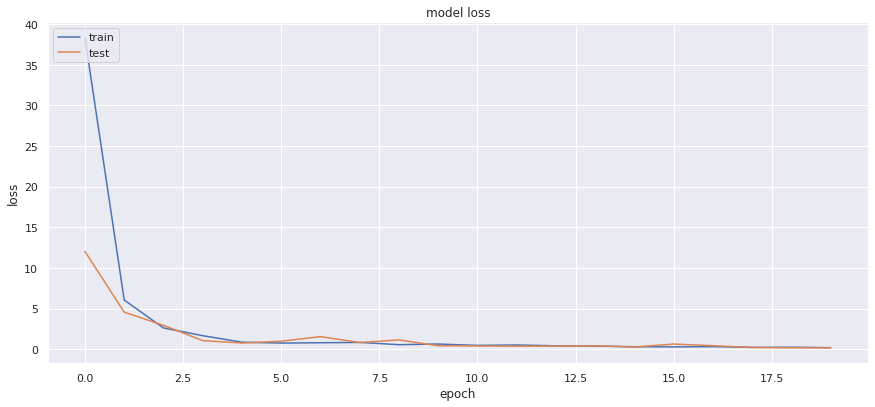

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
history.history['val_loss']

[12.019233703613281,
 4.550685882568359,
 2.9358179569244385,
 1.0490734577178955,
 0.751736044883728,
 0.976100742816925,
 1.541887879371643,
 0.8144891858100891,
 1.1361007690429688,
 0.41746196150779724,
 0.3972945809364319,
 0.36712443828582764,
 0.37799447774887085,
 0.41195663809776306,
 0.2650609314441681,
 0.6272944211959839,
 0.4260520040988922,
 0.20746257901191711,
 0.16561946272850037,
 0.1666867733001709]

In [ ]:
pred_test = test_dataset.loc[:]#, test_dataset.columns != 'BIOGAS_PRODUCTION_Q_DAY']
predictions = list()
for i in range(2,len(test_dataset)-10):
  x_input = array([pred_test.iloc[i-2], pred_test.iloc[i-1], pred_test.iloc[i]])
  x1 = x_input[:, 0].reshape((1, n_steps, n_features))
  x2 = x_input[:, 1].reshape((1, n_steps, n_features))
  x3 = x_input[:, 2].reshape((1, n_steps, n_features))
  x4 = x_input[:, 3].reshape((1, n_steps, n_features))
  x5 = x_input[:, 4].reshape((1, n_steps, n_features))
  x6 = x_input[:, 5].reshape((1, n_steps, n_features))
  x7 = x_input[:, 6].reshape((1, n_steps, n_features))
  x8 = x_input[:, 7].reshape((1, n_steps, n_features))
  x9 = x_input[:, 8].reshape((1, n_steps, n_features))
  x10 = x_input[:, 9].reshape((1, n_steps, n_features))
  x11 = x_input[:, 10].reshape((1, n_steps, n_features))
  yhat = model.predict([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11], verbose=0)
  predictions.append(yhat)

predicts= list()
for elem in predictions:
  predicts.append(elem[0][0])

#test_dataset['PREDICTED_BIOGAS'] = predictions

In [ ]:
print(predicts[0:10])
print(test_dataset.BIOGAS_PRODUCTION_Q_DAY.iloc[:10])

[2.411387, 2.3398216, 3.1470597, 3.2671678, 2.7126167, 2.9240088, 3.114271, 3.5851254, 2.6142626, 2.7347438]
Date
2014-03-11    2.475
2014-03-12    2.497
2014-03-13    3.185
2014-03-14    2.542
2014-03-15    3.052
2014-03-16    2.975
2014-03-17    2.983
2014-03-18    3.125
2014-03-19    3.218
2014-03-20    3.284
Name: BIOGAS_PRODUCTION_Q_DAY, dtype: float64


In [ ]:
test_dataset.iloc[2]

TPS_Q1_DAY                                        199.500
TPS_DS_DAY                                          5.000
TPS_VS_DAY                                         93.000
TWAS_DAF_QIN_DAY                                  124.500
TWAS_DAF_DS_DAY                                     3.000
TWAS_DAF_VS_DAY                                    83.000
DIGESTED_SLUDGE_QOUT_DAY                          343.000
DIGESTED_SLUDGE_DS_3_PER_WEEK                       2.200
DIGESTED_SLUDGE_VS_3_PER_WEEK                      78.000
BIOGAS_PRODUCTION_Q_DAY                             3.185
DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK     29.000
Name: 2014-03-13 00:00:00, dtype: float64

In [ ]:
#Date + 2
dti = pd.date_range("2014-03-13", periods=39, freq="D")


In [ ]:
test_dataset.drop(test_dataset.index[-10:], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
predictions_df = pd.DataFrame(data = predicts, index=dti)
test_dataset.drop(test_dataset.index[0:2], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


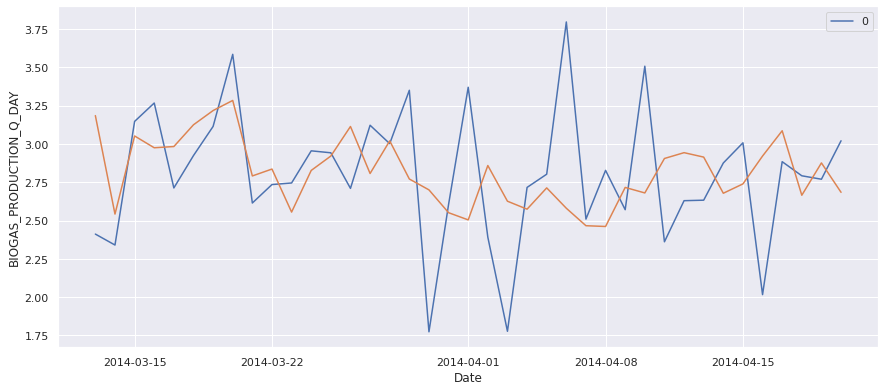

In [ ]:

sns.set(rc={'figure.figsize':(14.7,6.27)})
sns.lineplot(data=predictions_df)
sns.lineplot(data = test_dataset['BIOGAS_PRODUCTION_Q_DAY'])

In [ ]:
# Calculate Error:
errors = list()
for index, values in test_dataset.iterrows():
  #print(df_pca.loc[index]['BIOGAS_PRODUCTION_Q_DAY'])
  error = np.abs(((test_dataset.loc[index]['BIOGAS_PRODUCTION_Q_DAY'] - predictions_df.loc[index])/test_dataset.loc[index]['BIOGAS_PRODUCTION_Q_DAY']))
  errors.append(error[0])

errors = np.array(errors)
print(errors)
mape = np.mean(error)*100
print(mape)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

[0.24289263 0.07953518 0.03114668 0.09820767 0.09064141 0.06431717
 0.03223402 0.09169472 0.06332405 0.03570387 0.07439875 0.04525387
 0.00725312 0.12980174 0.11224611 0.00598534 0.20909401 0.3432437
 0.02126818 0.34584041 0.16367424 0.32345991 0.05519645 0.03294933
 0.47150967 0.01753927 0.14886599 0.05352556 0.30879212 0.18724838
 0.10655445 0.09654356 0.07375591 0.0979576  0.30983861 0.0654198
 0.04766867 0.03701103 0.12544264]
12.54426441675859
Accuracy: 87.46 %.


In [ ]:
all = pd.Series(data=pd.date_range(start=df_pca.index.min(), end=df_pca.index.max(), freq='d'))
mask = all.isin(df_pca.index.values)
print(all[~mask])

In [ ]:
sns.set(rc={'figure.figsize':(24.7,8.27)})
sns.lineplot(data=label)#, x="day", y="Bio-gas")